## Imports

In [1]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.metrics import *
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [3]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ImageFolderWithPaths(dset.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

train_dataset = ImageFolderWithPaths('../Dataset/train', transform=transform)
val_dataset = ImageFolderWithPaths('../Dataset/val', transform=transform)
test_dataset = ImageFolderWithPaths('../Dataset/test', transform=transform)

In [4]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
IngreLabel = open('../VireoFood172/SplitAndIngreLabel/IngreLabel.txt', 'r').read().split('\n')[:-1]  # list of str
path_to_ingredients = dict()
for i in range(len(IngreLabel)):
    path_and_ingredients = IngreLabel[i].split()
    path, ingredients = path_and_ingredients[0], [0 if int(label) == -1 else int(label) for label in path_and_ingredients[1:]]
    path_to_ingredients[path] = np.array(ingredients)

In [7]:
def get_ingredients(path):
    split_path = path.split("/")
    key = '/' + '/'.join(split_path[3:])
    ingredients = path_to_ingredients[key]
    return ingredients

In [8]:
IngreList = open('../VireoFood172/SplitAndIngreLabel/IngredientList.txt', 'r').read().split('\n')[:-1]  # list of str
print(len(IngreList))

353


## Creating ResNet model

In [11]:
# Use the pre-trained Res18 model on ImageNet
res18 = models.resnet18(pretrained=True) # models.resnet50(pretrained=True)
for param in res18.parameters():
    param.requires_grad = False
for param in res18.layer4.parameters(): # Update this from layer4 for resnet50
    param.requires_grad = True
res18.fc = nn.Linear(512, 1000)

# Use the pre-trained Res18 model on VireoFood172
# res18 = torch.load("../saved_models/food/res18/res18-unfreeze.dat")
# for param in res18.parameters():
#     param.requires_grad = False
# res18.fc = nn.Linear(512, 1000)

class MultiModal(nn.Module):
    def __init__(self, resnet):
        super(MultiModal, self).__init__()
        self.resnet = resnet
        self.relu = nn.ReLU()
        self.food = nn.Linear(1000, 172) # nn.Sequential(nn.Linear(1000, 4096), nn.ReLU(), nn.Dropout(), nn.Linear(4096, 172))
        self.ingredients = nn.Sequential(nn.Linear(1000, 353), nn.Sigmoid()) # nn.Sequential(nn.Linear(1000, 1024), nn.ReLU(), nn.Dropout(), nn.Linear(1024, 353), nn.Sigmoid())

    def forward(self, x):
        a = self.resnet(x)
        b = self.relu(a)
        food_output = self.food(b)
        ingredient_output = self.ingredients(b)
        return (food_output, ingredient_output)

model = MultiModal(res18)
optimizer = optim.Adam(model.parameters())
print(model)
model = gpu(model)

MultiModal(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [104]:
# Use the pre-trained Res50 model on ImageNet
res50 = models.resnet50(pretrained=True)
for param in res50.parameters():
    param.requires_grad = False
print(res50)

for param in res50.layer4.parameters():
    param.requires_grad = True

class MultiModal(nn.Module):
    def __init__(self, resnet):
        super(MultiModal, self).__init__()
        self.resnet = resnet
        self.relu = nn.ReLU()
        self.food = nn.Sequential(nn.Linear(1000, 4096), nn.ReLU(), nn.Dropout(), nn.Linear(4096, 172))
        self.ingredients = nn.Sequential(nn.Linear(1000, 1024), nn.ReLU(), nn.Dropout(), nn.Linear(1024, 353), nn.Sigmoid())

    def forward(self, x):
        a = self.resnet(x)
        b = self.relu(a)
        food_output = self.food(b)
        ingredient_output = self.ingredients(b)
        return (food_output, ingredient_output)

model = MultiModal(res50)
optimizer = optim.Adam(model.parameters())
print(model)
model = gpu(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training fully connected module

In [105]:
ingredient_criterion = nn.BCELoss()

### Training the model

In [106]:
# Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [107]:
def build_results(loss_history, food_accuracy_history, ingre_accuracy_history, 
                  micro_f1_history, macro_f1_history, samples_f1_history):
    results = dict()
    results['loss_history'] = loss_history
    results['food_accuracy_history'] = food_accuracy_history
    results['ingre_accuracy_history'] = ingre_accuracy_history
    results['micro_f1_history'] = micro_f1_history
    results['macro_f1_history'] = macro_f1_history
    results['samples_f1_history'] = samples_f1_history
    return results

In [108]:
def train_model(model, optimizer, epochs=1):
    train_loss_history, food_train_acc_history, ingre_train_acc_history = [], [], []
    train_micro_f1_history, train_macro_f1_history, train_samples_f1_history = [], [], []
    val_loss_history, food_val_acc_history, ingre_val_acc_history = [], [], []
    val_micro_f1_history, val_macro_f1_history, val_samples_f1_history = [], [], []
    for epoch in range(epochs):
        model.train()
        batches = train_dataloader
        food_num_correct, ingre_num_correct, num_samples, total_loss = 0, 0, 0, 0
        i = 0
        model_result = []
        targets = []
        for x, food_labels, paths in batches:
            if i % 100 == 0:
                print("Iteration: {}".format(i))
            x, food_labels = gpu(x), gpu(food_labels)
            ingre_labels = np.array([get_ingredients(path) for path in paths])
            x, ingre_labels = gpu(x), gpu(torch.from_numpy(ingre_labels)).to(torch.float32)
            (food_scores, ingre_scores) = model(x)
            _, food_preds = torch.max(food_scores.data, 1)
            
            loss_food = F.cross_entropy(food_scores, food_labels)
            loss_ingre = criterion(ingre_scores, ingre_labels)   
            loss = loss_food + loss_ingre
            loss = loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
            food_num_correct += torch.sum(food_preds == food_labels.data)
            ingre_num_correct += get_ingre_num_correct(ingre_scores, ingre_labels)
            num_samples += x.size(0)
            i += 1
            
            model_result.extend(ingre_scores.detach().cpu().numpy())
            targets.extend(ingre_labels.detach().cpu().numpy())
        result = calculate_metrics(np.array(model_result), np.array(targets))
        micro_f1, macro_f1, samples_f1 = result['micro/f1'], result['macro/f1'], result['samples/f1']
        print("Epoch:{:2d} Training: "
              "Micro F1: {:.3f} "
              "Macro F1: {:.3f} "
              "Samples F1: {:.3f}".format(epoch + 1, micro_f1, macro_f1, samples_f1))
        average_loss = total_loss / num_samples
        
        food_acc = food_num_correct / num_samples
        ingre_acc = ingre_num_correct / num_samples
        
        train_loss_history.append(average_loss)
        food_train_acc_history.append(food_acc)
        ingre_train_acc_history.append(ingre_acc)
        train_micro_f1_history.append(micro_f1)
        train_macro_f1_history.append(macro_f1)
        train_samples_f1_history.append(samples_f1)
        print('Epoch: {} Training Loss: {:.8f} Got {} / {} correct. Food Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, food_num_correct, num_samples, 100 * food_acc))
        print('Epoch: {} Training Loss: {:.8f} Got {} / {} correct. Ingredient Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, ingre_num_correct, num_samples, 100 * ingre_acc))
        
        check_accuracy(model, val_loss_history, food_val_acc_history, ingre_val_acc_history,
                       val_micro_f1_history, val_macro_f1_history, val_samples_f1_history,
                       epoch)
    train_results = build_results(train_loss_history, food_train_acc_history, ingre_train_acc_history,
                                  train_micro_f1_history, train_macro_f1_history, train_samples_f1_history)
    val_results = build_results(val_loss_history, food_val_acc_history, ingre_val_acc_history,
                                val_micro_f1_history, val_macro_f1_history, val_samples_f1_history)
    results = dict()
    results['train'] = train_results
    results['val'] = val_results
    return results

def check_accuracy(model, val_loss_history, food_val_acc_history, ingre_val_acc_history,
                   val_micro_f1_history, val_macro_f1_history, val_samples_f1_history,
                   epoch):
    food_num_correct, ingre_num_correct, num_samples, total_loss = 0, 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        model_result = []
        targets = []
        for x, food_labels, paths in batches:
            x, food_labels = gpu(x), gpu(food_labels)
            ingre_labels = np.array([get_ingredients(path) for path in paths])
            ingre_labels = gpu(torch.from_numpy(ingre_labels)).to(torch.float32)
            (food_scores, ingre_scores) = model(x)
            _, food_preds = torch.max(food_scores.data, 1)
            
            loss_food = F.cross_entropy(food_scores, food_labels)
            loss_ingre = criterion(ingre_scores, ingre_labels)   
            loss = loss_food + loss_ingre
            
            total_loss += loss.data.item()
            food_num_correct += torch.sum(food_preds == food_labels.data)
            ingre_num_correct += get_ingre_num_correct(ingre_scores, ingre_labels)
            num_samples += x.size(0)
            
            model_result.extend(ingre_scores.detach().cpu().numpy())
            targets.extend(ingre_labels.detach().cpu().numpy())
        result = calculate_metrics(np.array(model_result), np.array(targets))
        micro_f1, macro_f1, samples_f1 = result['micro/f1'], result['macro/f1'], result['samples/f1']
        print("Epoch:{:2d} Validation: "
              "Micro F1: {:.3f} "
              "Macro F1: {:.3f} "
              "Samples F1: {:.3f}".format(epoch + 1,
                                          micro_f1,
                                          macro_f1,
                                          samples_f1))
        average_loss = total_loss / num_samples
        
        food_acc = food_num_correct / num_samples
        ingre_acc = ingre_num_correct / num_samples
        
    val_loss_history.append(average_loss)
    food_val_acc_history.append(food_acc)
    ingre_val_acc_history.append(ingre_acc)
    val_micro_f1_history.append(micro_f1)
    val_macro_f1_history.append(macro_f1)
    val_samples_f1_history.append(samples_f1)
    print('Epoch: {} Validation Loss: {:.8f} Got {} / {} correct. Food Acc: {:.2f}%'.format(
        epoch + 1, average_loss, food_num_correct, num_samples, 100 * food_acc))
    print('Epoch: {} Validation Loss: {:.8f} Got {} / {} correct. Ingredient Acc: {:.2f}%'.format(
        epoch + 1, average_loss, ingre_num_correct, num_samples, 100 * ingre_acc))

def get_ingre_num_correct(ingre_scores, ingre_labels):
    ingre_scores[ingre_scores >= 0.5] = 1
    ingre_scores[ingre_scores < 0.5] = 0
    ingre_num_correct = (ingre_scores == ingre_labels).all(dim=1).sum().item()
    return ingre_num_correct

In [109]:
%%time
num_epochs = 10
results = train_model(gpu(model), optimizer, epochs=num_epochs)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 Training: Micro F1: 0.578 Macro F1: 0.371 Samples F1: 0.567
Epoch: 1 Training Loss: 0.00739839 Got 58685 / 66071 correct. Food Acc: 88.82%
Epoch: 1 Training Loss: 0.00739839 Got 12666 / 66071 correct. Ingredient Acc: 19.17%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 1 Validation: Micro F1: 0.568 Macro F1: 0.362 Samples F1: 0.526
Epoch: 1 Validation Loss: 0.02832870 Got 7695 / 11016 correct. Food Acc: 69.85%
Epoch: 1 Validation Loss: 0.02832870 Got 2121 / 11016 correct. Ingredient Acc: 19.25%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 Training: Micro F1: 0.677 Macro F1: 0.456 Samples F1: 0.667
Epoch: 2 Training Loss: 0.00511408 Got 60977 / 66071 correct. Food Acc: 92.29%
Epoch: 2 Training Loss: 0.00511408 Got 16080 / 66071 correct. Ingredient Acc: 24.34%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 2 Validation: Micro F1: 0.578 Macro F1: 0.372 Samples F1: 0.536
Epoch: 2 Validation Loss: 0.03081393 Got 7705 / 11016 correct. Food Acc: 69.94%
Epoch: 2 Validation Loss: 0.03081393 Got 2169 / 11016 correct. Ingredient Acc: 19.69%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 Training: Micro F1: 0.689 Macro F1: 0.468 Samples F1: 0.683
Epoch: 3 Training Loss: 0.00448974 Got 61695 / 66071 correct. Food Acc: 93.38%
Epoch: 3 Training Loss: 0.00448974 Got 16826 / 66071 correct. Ingredient Acc: 25.47%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 3 Validation: Micro F1: 0.578 Macro F1: 0.372 Samples F1: 0.542
Epoch: 3 Validation Loss: 0.02960059 Got 7784 / 11016 correct. Food Acc: 70.66%
Epoch: 3 Validation Loss: 0.02960059 Got 2224 / 11016 correct. Ingredient Acc: 20.19%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 Training: Micro F1: 0.693 Macro F1: 0.475 Samples F1: 0.689
Epoch: 4 Training Loss: 0.00418668 Got 62039 / 66071 correct. Food Acc: 93.90%
Epoch: 4 Training Loss: 0.00418668 Got 16972 / 66071 correct. Ingredient Acc: 25.69%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 4 Validation: Micro F1: 0.597 Macro F1: 0.383 Samples F1: 0.560
Epoch: 4 Validation Loss: 0.03086461 Got 7842 / 11016 correct. Food Acc: 71.19%
Epoch: 4 Validation Loss: 0.03086461 Got 2392 / 11016 correct. Ingredient Acc: 21.71%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 Training: Micro F1: 0.699 Macro F1: 0.480 Samples F1: 0.696
Epoch: 5 Training Loss: 0.00390765 Got 62398 / 66071 correct. Food Acc: 94.44%
Epoch: 5 Training Loss: 0.00390765 Got 17497 / 66071 correct. Ingredient Acc: 26.48%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 5 Validation: Micro F1: 0.588 Macro F1: 0.377 Samples F1: 0.550
Epoch: 5 Validation Loss: 0.03199543 Got 7676 / 11016 correct. Food Acc: 69.68%
Epoch: 5 Validation Loss: 0.03199543 Got 2260 / 11016 correct. Ingredient Acc: 20.52%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 Training: Micro F1: 0.704 Macro F1: 0.487 Samples F1: 0.702
Epoch: 6 Training Loss: 0.00354196 Got 62773 / 66071 correct. Food Acc: 95.01%
Epoch: 6 Training Loss: 0.00354196 Got 17576 / 66071 correct. Ingredient Acc: 26.60%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 6 Validation: Micro F1: 0.586 Macro F1: 0.383 Samples F1: 0.553
Epoch: 6 Validation Loss: 0.03339667 Got 7822 / 11016 correct. Food Acc: 71.01%
Epoch: 6 Validation Loss: 0.03339667 Got 2304 / 11016 correct. Ingredient Acc: 20.92%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 Training: Micro F1: 0.706 Macro F1: 0.488 Samples F1: 0.704
Epoch: 7 Training Loss: 0.00359706 Got 62760 / 66071 correct. Food Acc: 94.99%
Epoch: 7 Training Loss: 0.00359706 Got 17641 / 66071 correct. Ingredient Acc: 26.70%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 7 Validation: Micro F1: 0.585 Macro F1: 0.381 Samples F1: 0.547
Epoch: 7 Validation Loss: 0.03077454 Got 7799 / 11016 correct. Food Acc: 70.80%
Epoch: 7 Validation Loss: 0.03077454 Got 2282 / 11016 correct. Ingredient Acc: 20.72%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 Training: Micro F1: 0.708 Macro F1: 0.494 Samples F1: 0.708
Epoch: 8 Training Loss: 0.00328848 Got 63007 / 66071 correct. Food Acc: 95.36%
Epoch: 8 Training Loss: 0.00328848 Got 17962 / 66071 correct. Ingredient Acc: 27.19%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 8 Validation: Micro F1: 0.585 Macro F1: 0.382 Samples F1: 0.552
Epoch: 8 Validation Loss: 0.03204806 Got 7813 / 11016 correct. Food Acc: 70.92%
Epoch: 8 Validation Loss: 0.03204806 Got 2348 / 11016 correct. Ingredient Acc: 21.31%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 Training: Micro F1: 0.712 Macro F1: 0.499 Samples F1: 0.713
Epoch: 9 Training Loss: 0.00295923 Got 63324 / 66071 correct. Food Acc: 95.84%
Epoch: 9 Training Loss: 0.00295923 Got 18170 / 66071 correct. Ingredient Acc: 27.50%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 9 Validation: Micro F1: 0.579 Macro F1: 0.377 Samples F1: 0.542
Epoch: 9 Validation Loss: 0.03516824 Got 7687 / 11016 correct. Food Acc: 69.78%
Epoch: 9 Validation Loss: 0.03516824 Got 2303 / 11016 correct. Ingredient Acc: 20.91%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:10 Training: Micro F1: 0.713 Macro F1: 0.497 Samples F1: 0.714
Epoch: 10 Training Loss: 0.00295782 Got 63393 / 66071 correct. Food Acc: 95.95%
Epoch: 10 Training Loss: 0.00295782 Got 18206 / 66071 correct. Ingredient Acc: 27.56%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch:10 Validation: Micro F1: 0.589 Macro F1: 0.383 Samples F1: 0.556
Epoch: 10 Validation Loss: 0.03074288 Got 7925 / 11016 correct. Food Acc: 71.94%
Epoch: 10 Validation Loss: 0.03074288 Got 2414 / 11016 correct. Ingredient Acc: 21.91%
CPU times: user 25min 38s, sys: 6min 18s, total: 31min 56s
Wall time: 45min 47s


In [103]:
saved_results = results

In [110]:
# Save the model.
PATH = '../saved_models/ingredients/multi_modal/multi_modal_2.dat' # Uses a Res50 backbone CNN
torch.save(model, PATH)
torch.save(results, '../saved_models/ingredients/multi_modal/multi_modal_2-results.pt')

## Evaluation

In [12]:
# Load the model.
PATH = '../saved_models/ingredients/multi_modal/multi_modal.dat' # Uses a Res18 backbone CNN
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
results = torch.load('../saved_models/ingredients/multi_modal/multi_modal-results.pt')

In [16]:
train_results, val_results = results['train'], results['val']
LOSS, FOOD_ACC, LOSS_V, FOOD_ACC_V = (train_results['loss_history'], train_results['food_accuracy_history'], 
                                      val_results['loss_history'], val_results['food_accuracy_history'])
INGRE_ACC, INGRE_ACC_V = (train_results['ingre_accuracy_history'], val_results['ingre_accuracy_history'])

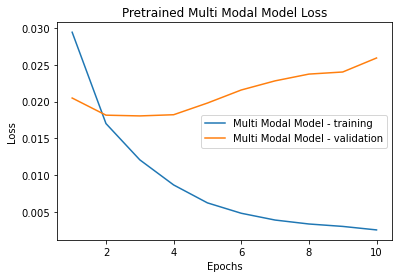

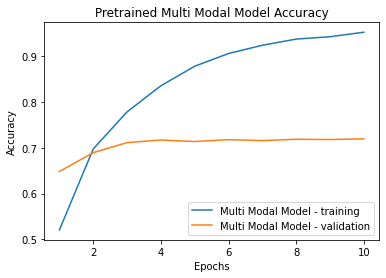

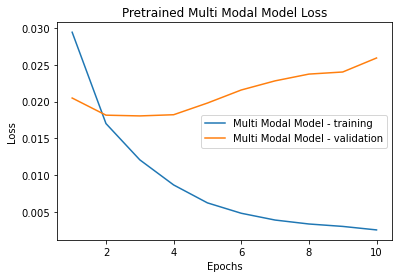

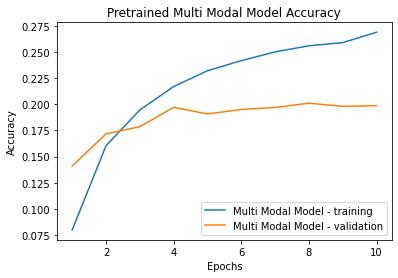

In [18]:
# Loss and Accuracy Curves
from utils.plots import plot_loss_and_accuracy_curves
plot_loss_and_accuracy_curves('Multi Modal Model', LOSS, FOOD_ACC, LOSS_V, FOOD_ACC_V)
plot_loss_and_accuracy_curves('Multi Modal Model', LOSS, INGRE_ACC, LOSS_V, INGRE_ACC_V)

In [19]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels, paths = data
            images = gpu(images)
            labels = gpu(labels)
            (food_scores, ingredient_scores) = model(images)
            _, predicted = torch.max(food_scores.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Top 1 Accuracy of the network on the all test images: 71.53 %


In [20]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels, paths = data
            images = gpu(images)
            labels = gpu(labels)
            (food_scores, ingredient_scores) = model(images)
            _, predicted = torch.topk(food_scores.data, 5, dim=1)
            total += labels.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = labels[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 90.97 %


In [120]:
# Evaluation: Compute Accuracy and Micro F1, Macro F1, Samples F1 scores

def compute_accuracy(model):
    num_correct, num_samples, total_loss = 0, 0, 0
    with torch.no_grad():
        model.eval()
        model_result = []
        targets = []
        for x, food_labels, paths in test_dataloader:
            y = np.array([get_ingredients(path) for path in paths])
            x, y = gpu(x), gpu(torch.from_numpy(y)).to(torch.float32)
            (food_scores, ingredient_scores) = model(x)
            loss = criterion(ingredient_scores, y) 
            total_loss += loss.data.item()
            num_correct += get_ingre_num_correct(ingredient_scores, y)
            num_samples += x.size(0)
            
            model_result.extend(ingredient_scores.cpu().numpy())
            targets.extend(y.cpu().numpy())
        result = calculate_metrics(np.array(model_result), np.array(targets))
        micro_f1, macro_f1, samples_f1 = result['micro/f1'], result['macro/f1'], result['samples/f1']
        print("Testing: "
              "Micro F1: {:.3f} "
              "Macro F1: {:.3f} "
              "Samples F1: {:.3f}".format(result['micro/f1'],
                                          result['macro/f1'],
                                          result['samples/f1']))
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples

    print('Accuracy of the network on the all test images: %.2f%%' % (
        100 * num_correct / num_samples))

compute_accuracy(model)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testing: Micro F1: 0.586 Macro F1: 0.380 Samples F1: 0.550
Accuracy of the network on the all test images: 21.80%


## Precision + Recall Statistics

We compute aggregate precision-recall stats as well as precision-recall stats on a per-ingredient basis.
Store the predictions made by the model in y_score and the correct labels in y_test for all the testing examples.

In [21]:
y_score = []
y_test = []
criterion = nn.BCELoss()
with torch.no_grad():
    model.eval()
    for x, food_labels, paths in test_dataloader:
        y = np.array([get_ingredients(path) for path in paths])
        x, y = gpu(x), gpu(torch.from_numpy(y)).to(torch.float32)
        (food_scores, ingre_scores) = model(x)
        y_score.extend(ingre_scores.cpu().numpy())
        y_test.extend(y.cpu().numpy())

In [22]:
y_score = np.array(y_score)
y_test = np.array(y_test)

Store the thresholded predictions made by the model in y_pred (using a default threshold of 0.5 for each ingredient category)

In [23]:
y_pred = np.array(y_score > 0.5, dtype=float)

### Compute Precision/Recall for each Ingredient Manually

In [24]:
# Manual Precision/Recall Calculations:
from collections import defaultdict

num_classes = 353
pr_stats = dict()
for j in range(num_classes):
    pr_stats[j] = defaultdict(int)
for (y_test_i, y_pred_i) in zip(y_test, y_pred):
    for j in range(num_classes):
        if y_test_i[j] == 0 and y_pred_i[j] == 0:
            pr_stats[j]["TN"] += 1
        elif y_test_i[j] == 1 and y_pred_i[j] == 1:
            pr_stats[j]["TP"] += 1
        elif y_test_i[j] == 1 and y_pred_i[j] == 0:
            pr_stats[j]["FN"] += 1
        elif y_test_i[j] == 0 and y_pred_i[j] == 1:
            pr_stats[j]["FP"] += 1

In [25]:
precision = dict()
recall = dict()
dash = '-' * 75
print("Precision-Recall Statistics for each Ingredient")
print(dash)
print('{:<50s}{:^10s}{:^15s}'.format("Ingredient", "Precision", "Recall"))
print(dash)
for j in range(num_classes):
    if (pr_stats[j]["TP"] + pr_stats[j]["FP"]) == 0:
        precision[j] = 0
    else:
        precision[j] = pr_stats[j]["TP"] / (pr_stats[j]["TP"] + pr_stats[j]["FP"])
        
    if (pr_stats[j]["TP"] + pr_stats[j]["FN"]) == 0:
        recall[j] = 0
    else:
        recall[j] = pr_stats[j]["TP"] / (pr_stats[j]["TP"] + pr_stats[j]["FN"])
    print('{:<50s}{:^10.2f}{:^15.2f}'.format(IngreList[j], precision[j], recall[j]))  

Precision-Recall Statistics for each Ingredient
---------------------------------------------------------------------------
Ingredient                                        Precision     Recall     
---------------------------------------------------------------------------
Minced green onion                                   0.72        0.40      
chiffonade of green onion                            0.76        0.31      
Seared green onion                                   0.31        0.04      
White onion                                          0.71        0.69      
Brunoise diced ham                                   0.70        0.69      
Julienned ham                                        0.00        0.00      
Ham                                                  0.67        0.08      
Sliced ham                                           0.00        0.00      
Brunoise diced carrot                                0.69        0.50      
Sliced carrot                           

### Sklearn Classification Report

In [26]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=IngreList))


Accuracy: 0.20

Micro Precision: 0.75
Micro Recall: 0.47
Micro F1-score: 0.58



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.55
Macro Recall: 0.36
Macro F1-score: 0.41



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Precision: 0.72
Weighted Recall: 0.47
Weighted F1-score: 0.55

Classification Report

                                            precision    recall  f1-score   support

                        Minced green onion       0.72      0.40      0.52      6698
                 chiffonade of green onion       0.76      0.31      0.44       666
                        Seared green onion       0.31      0.04      0.07       731
                               White onion       0.71      0.69      0.70       144
                        Brunoise diced ham       0.70      0.69      0.69       435
                             Julienned ham       0.00      0.00      0.00        10
                                       Ham       0.67      0.08      0.15        24
                                Sliced ham       0.00      0.00      0.00        46
                     Brunoise diced carrot       0.69      0.50      0.58       868
                             Sliced carrot       0.45      0.06 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Precision-Recall Curves (to investigate the effect of different thresholds)

Note: this code was modified from https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 353
thresholds = dict()
for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.64


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.64')

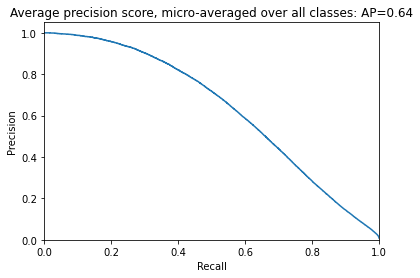

In [28]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

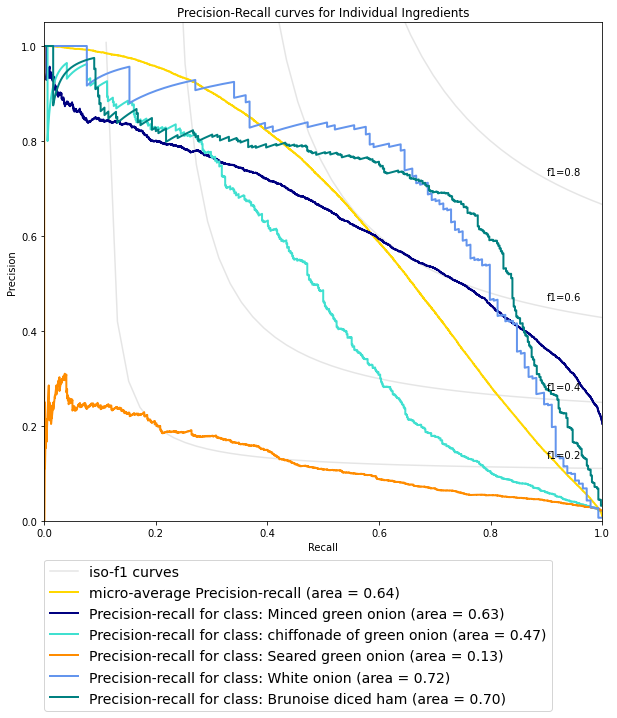

In [29]:
from itertools import cycle
# setup plot details
num_classes = 5
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(10, 11))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class: {0} (area = {1:0.2f})'
                  ''.format(IngreList[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curves for Individual Ingredients')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

## Investigate one of the ingredients with 0 Precision and Recall (e.g.:julienned ham)

In [32]:
ham_index = 5
ham_pred, ham_test = 0, 0
for (y_test_i, y_pred_i) in zip(y_test, y_pred):
    if y_test_i[ham_index] == 1:
        ham_test += 1
    if y_pred_i[ham_index] == 1:
        ham_pred += 1
print("Number of testing examples with julienned ham as an ingredient: {}".format(ham_test))
print("Number of testing examples where the model predicted julienned ham as an ingredient: {}".format(ham_pred))

Number of testing examples with julienned ham as an ingredient: 10
Number of testing examples where the model predicted julienned ham as an ingredient: 0
